Tommaso Peritore

In [1]:
#matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.gridspec as gridspec
from scipy.optimize import curve_fit
import statsmodels.api as sm

#numpy
import numpy as np

#center graphs
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
	display: table-cell;
	text-align: center;
	vertical-align: middle;
}
</style>
""")
colors = ["steelblue" , "firebrick" , "cadetblue" , "indianred"]


# Exercise 08

The variational principle in Quantum Mechanics states that the expectation value of the Hamiltonian over a (good) trial quantum state has the ground state energy $E_0$ as lower bound:

$$
\langle {\hat H} \rangle_T = 
\frac{\int dx \Psi^*_T(x) {\hat H} \Psi_T(x)}
{\int dx |\Psi_T(x)|^2} \ge E_0 =
\frac{\langle \Psi_0| {\hat H} | \Psi_0 \rangle}
{\langle \Psi_0 | \Psi_0 \rangle}
$$

During this exercise you will variationally optimize the ground state of a single quantum particle in a one dimensional (1D) space confined by the following external potential:
$$
V(x) = x^4 - \frac{5}{2}x^2
$$

This 1D quantum model is not analytically solvable and should be attacked by numerical methods. In order to obtain an approximate wave function for the ground state, the Variational Monte Carlo method uses a trial wave function, parametrized by a set of variational parameters. An approximate model for the ground state wave function is the following trial wave function:
$$
\Psi_T^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+
                               e^{-\frac{(x+\mu)^2}{2\sigma^2}}
$$

$\Psi_T^{\sigma,\mu}(x)$ depends on two variational parameters: $\sigma$ and $\mu$.

## 8.1

Write a Variational Monte Carlo code for a single quantum particle in 1D which exploits the Metropolis algorithm to sample the square modulus of our trial wave function $|\Psi_T^{\sigma,\mu}(x)|^2$ using an uniform transition probability $T(x_{new}|x_{old})$. By using data blocking, the code should be able to compute the expectation value for the Hamiltonian

$$
\langle {\hat H} \rangle_T = 
\frac{\int dx \Psi^*_T(x) {\hat H} \Psi_T(x)}
{\int dx |\Psi_T(x)|^2} = 
\int dx \frac{|\Psi_T(x)|^2}{\int dx |\Psi_T(x)|^2} \frac{{\hat H} \Psi_T(x)}{\Psi_T(x)}
$$

which can be used to find the parameters that minimize this quantity. Use $\hbar = 1$ and $m=1$.
Note that to measure $\langle {\hat H} \rangle_T$ you need the analytical calculation of:
    
$$
-\frac{\hbar^2}{2m}\frac{\partial^2 \Psi_T^{\sigma,\mu}(x)}{\partial x^2} \cdot \frac{1}{\Psi_T^{\sigma,\mu}(x)}
$$

## Solution

In order to evaluate the average value of the Hamiltonian, i.e. the expectation value of ${\hat H}$ on a certain trial state $\langle\Psi_T|{\hat H}|\Psi_T\rangle$, the hint we were given is to multiply and divide by $\Psi_T$. This is useful since it gives inside the integral a probability that we are able to sample, and then the Hamiltonian applied onto the wavefunction, which is analytically solvable and thus we can implement it. In fact, if we define 
$$\rho(x) = \frac{|\Psi_T(x)|^2}{\int dx |\Psi_T(x)|^2} $$
then the expectation value of ${\hat H}$ is reduced to 
$$\int dx \rho(x) \frac{{\hat H} \Psi_T(x)}{\Psi_T(x)}$$
which we can easily exploit Metropolis to evaluate as the $\rho(x)$ can be used as the probability distribution that the Metropolis algorithm requires. This also solves another problem we had, which is the impossibility to calculate the normalization of the wavefunction. In MR^2, in fact, this probability is only needed when calculating the acceptance, where the normalization cancels out thanks to the ratio of $\rho(y)/\rho(x)$. 
$$ a = \min \left(1, \frac{\rho(x')}{\rho(x)}\right) = \min \left(1,\frac{|\Psi_T(x')|^2}{|\Psi_T(x)|^2}\right) $$
where $x'$ is the new position picked at random with $x'=x+y\delta$ where $y\in(0,1)$ and $\delta$ is the parameter chosen for step size. Metropolis will accept or not this new position with probability of $a$.

Finally we have to apply the Hamiltonian onto our wavefunction. The kinetic part takes some analytic calculation to obtain the second derivative:
$$
\frac{\partial^2 \Psi_T^{\sigma,\mu}(x)}{\partial x^2}\frac{1}{\Psi_T^{\sigma,\mu}(x)} =
\frac{
    \frac{1}{\sigma^2} - \left( \frac{x - \mu}{\sigma^2} \right)^2 +
    \left( \frac{1}{\sigma^2} - \left( \frac{x + \mu}{\sigma^2} \right)^2 \right) \cdot \exp\left( -2 \cdot \frac{\mu \cdot x}{\sigma^2} \right)
}{
    2 + 2 \cdot \exp\left( -2 \cdot \frac{\mu \cdot x}{\sigma^2} \right)
}
$$

$$ 
-\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2} \Psi_T^{\sigma,\mu}(x) \cdot \frac{1}{\Psi_T^{\sigma,\mu}(x)}
 = \frac{x}{2 \sigma^2} - \frac{\mu}{2 \sigma^2} \cdot \frac{1 - \exp\left(-2 \cdot \frac{\mu x}{\sigma^2}\right)}{1 + \exp\left(-2 \cdot \frac{\mu x}{\sigma^2}\right)}
$$

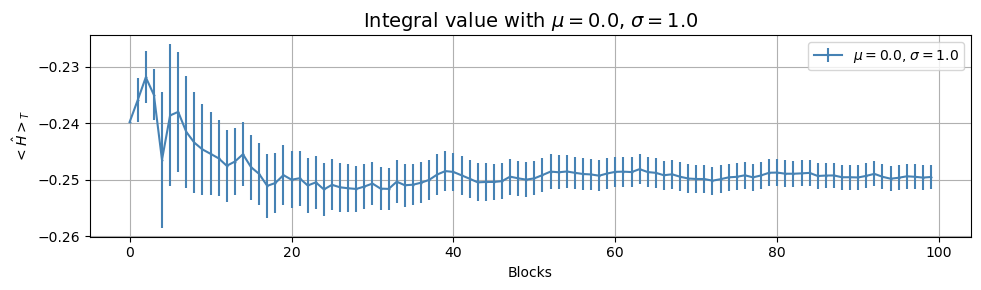

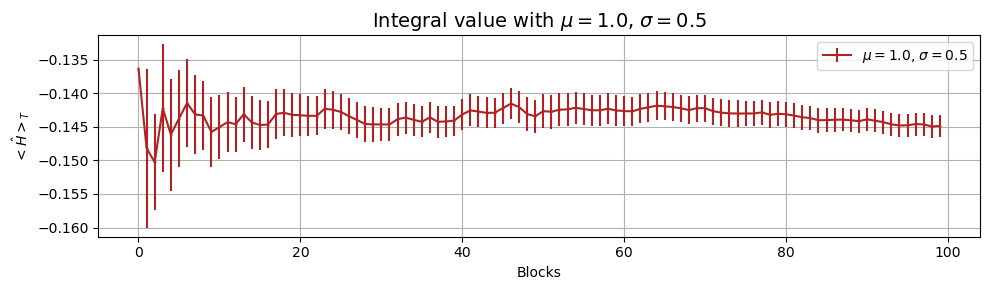

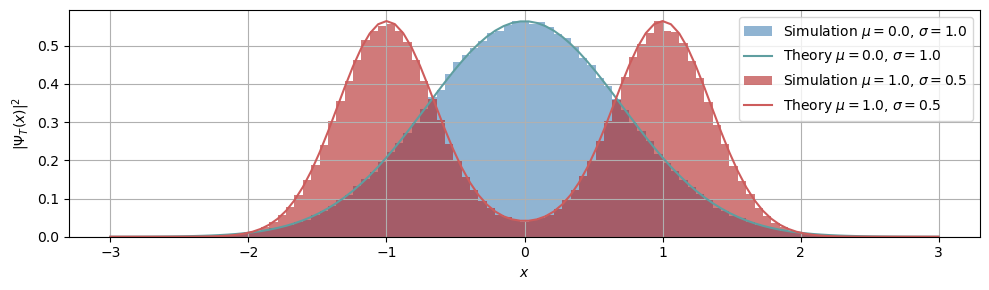

In [2]:
# Function to evaluate the squared wavefunction
def EvalWaveFunctionSquared(x, mu, sigma):
    return (np.exp(-(x-mu)**2/(2*sigma**2))+np.exp((-(x+mu)**2/(2*sigma**2))))**2

# Function to generate a graph for the Hamiltonian
def hamiltonianGraph(mu, sigma, color):
    # Convert float to string with 3 decimal places
    mu_str = f"{mu:.1f}"
    sigma_str = f"{sigma:.1f}"

    plt.figure(figsize=(10, 3))
    x, y, error = np.loadtxt(f'./8.1/HamiltonianExpValue_{mu_str}_{sigma_str}.dat', unpack=True, usecols=(0, 2, 3))
    plt.errorbar(x, y, yerr=error, marker='o', markersize=0.5, label=f'$\mu = {mu_str}$, $\sigma = {sigma_str}$', color=color)
    plt.title(f'Integral value with $\mu = {mu_str}$, $\sigma = {sigma_str}$', fontsize=14)
    plt.ylabel('$<\\hat{H}>_T$')
    plt.xlabel('Blocks')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# Function to generate a histogram for the wavefunction
def wavefunctionHisto(mu, sigma, norm, color1, color2):
    # Convert float to string with 3 decimal places
    mu_str = f"{mu:.1f}"
    sigma_str = f"{sigma:.1f}"

    positions = np.loadtxt(f'./8.1/Coordinates_{mu_str}_{sigma_str}.dat', usecols=(1))
    plt.hist(positions, density=True, bins=np.linspace(-3, 3, 100), label=f'Simulation $\mu = {mu_str}$, $\sigma = {sigma_str}$', alpha=0.6, color=color1)
    plt.plot(np.linspace(-3, 3, 100), 1 / (norm*np.sqrt(np.pi)) * EvalWaveFunctionSquared(np.linspace(-3, 3, 100), mu, sigma), color=color2, label=f'Theory $\mu = {mu_str}$, $\sigma = {sigma_str}$')


# Test the functions with formatted floats
hamiltonianGraph(0.0, 1.0, colors[0])
hamiltonianGraph(1.0, 0.5, colors[1])


plt.figure(figsize=(10, 3))
wavefunctionHisto(0.0, 1.0, 4, colors[0], colors[2])
wavefunctionHisto(1.0, 0.5, 1, colors[1], colors[3])

plt.legend()
plt.xlabel('$x$')
plt.ylabel('$|\\Psi_T(x)|^2$')
plt.grid()
plt.tight_layout()
plt.show()


## 08.2

To find the parameters $\sigma$ and $\mu$ which minimize $\langle {\hat H} \rangle_T$, extend your Variational Monte Carlo code to face the variational optimization problem via a Simulated Annealing (SA) algorithm.

Choose an appropriate starting temperature for your SA algorithm and an appropriate temperature-update-law to make the optimization work.

Compute $\langle {\hat H} \rangle_T$ with enough statistics in order to be able to measure the lowering of $\langle {\hat H} \rangle_T$ once the variational parameters are moved.
- Show a picture of $\langle {\hat H} \rangle_T$ (with statistical uncertainties) as a function of the SA steps of the algorithm
- you could also show a picture of the trajectory of the SA algorithm in the variational parameter space as a function of the SA steps
- show a picture of the estimation of $\langle {\hat H} \rangle_T$ and its statistical uncertainty as a function of the number of blocks/MC steps for the set of parameters which minimize $\langle {\hat H} \rangle_T$
- show also a picture **of the sampled** $|\Psi_T(x)|^2$ by filling a histogram with the sampled configurations, moreover compare it with the analytic curve of $|\Psi_T(x)|^2$ and with the numerical solution obtained by transforming the Schrodinger equation into a matrix equation (see below the supplementary material).

### Supplementary material

How can we describe a wave function as a vector? We set up a lattice of discrete points, spaced by a constant distance $dx$, and record the value of the function at each lattice point. In this way the wave function, $\Psi(x)$ become a vector:

$$
\Psi(x) \to \left[ \Psi(x_1), \Psi(x_2), ..., \Psi(x_N) \right] = 
\left[ \Psi_1, \Psi_2, ..., \Psi_N \right]
$$

The time independent Schrodinger equation 

$$
{\hat H} \Psi(x) = \left( -\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2} + V(x) \right) \Psi(x) = E \Psi(x)
$$

can be written in matrix form. But how do we write the second derivative at a particular point? Let's start with the first derivatives:
$$
\frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i+1})/2\right) \simeq \frac{\Psi_{i+1}-\Psi_{i}}{dx}\\
\frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i-1})/2\right) \simeq \frac{\Psi_{i}-\Psi_{i-1}}{dx}
$$

Thus, we can discretize the second derivative in the following way:
$$
\frac{\partial^2}{\partial x^2} \Psi(x=x_i) =
\frac{\frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i+1})/2\right) - \frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i-1})/2\right)}{dx} =
\frac{\Psi_{i+1}-2\Psi_{i}+\Psi_{i-1}}{dx^2}
$$

We finally obtain:

$$
\begin{bmatrix}
 \frac{\hbar^2}{m\,dx^2}+V(x_1)& -\frac{\hbar^2}{2m\,dx^2} & 0 & \dots  & 0 \\
-\frac{\hbar^2}{2m\,dx^2} & \frac{\hbar^2}{m\,dx^2}+V(x_2) & -\frac{\hbar^2}{2m\,dx^2} & \dots  & 0 \\
 0                        & -\frac{\hbar^2}{2m\,dx^2} & \frac{\hbar^2}{m\,dx^2}+V(x_3) & \dots  & 0 \\
 \vdots                   & \vdots                    & \vdots & \ddots & \vdots \\
 0                    & 0                & 0 & \dots  & \frac{\hbar^2}{m\,dx^2}+V(x_N)
\end{bmatrix}
\begin{bmatrix}
\Psi_{1} \\
\Psi_{2} \\
\vdots \\
\Psi_{N}
\end{bmatrix}
= E
\begin{bmatrix}
\Psi_{1} \\
\Psi_{2} \\
\vdots \\
\Psi_{N}
\end{bmatrix}
$$

To solve the time independent Schrodinger equation we therefore have to find eigenstates and eigenvalues of the matrix just obtained.

Ground state energy:  -0.4604658796923901
1st excited state energy:  0.09742471331806084
2nd excited state energy:  1.9717331343935816


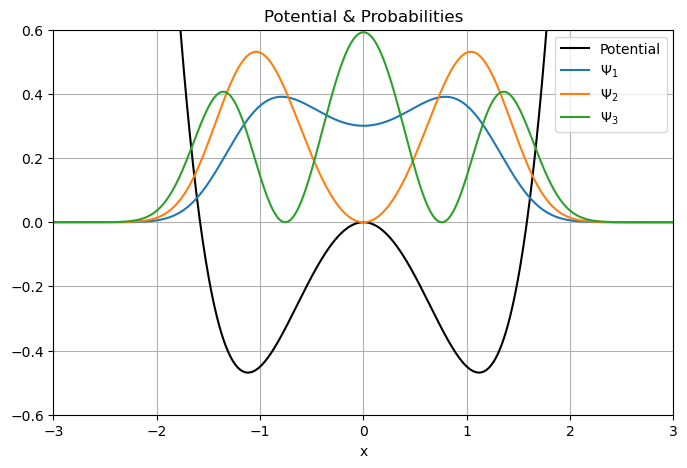

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def Vpot(x):
    return (x**2 - 2.5)*x**2
    #return 0.5*x**2

hbar = 1
m = 1
a = 10
N = 1000 # number of iterations

# Step sizes
x = np.linspace(-a/2, a/2, N)
dx = x[1] - x[0] # the step size
V = Vpot(x)

# The central differences method: f" = (f_1 - 2*f_0 + f_-1)/dx^2

CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
# np.diag(np.array,k) construct a "diagonal" matrix using the np.array
# The default is k=0. Use k>0 for diagonals above the main diagonal, 
# and k<0 for diagonals below the main diagonal

# Hamiltonian matrix
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)

# Compute eigenvectors and their eigenvalues
E,psi = np.linalg.eigh(H)

# Take the transpose & normalize
psi = np.transpose(psi)
psi = psi/np.sqrt(dx)

print("Ground state energy: ", E[0])
print("1st excited state energy: ", E[1])
print("2nd excited state energy: ", E[2])

# Plot a few things
plt.figure(figsize=(8,5))
scale = 0.3
plt.plot(x, scale*V, color="Black", label="Potential") # plot the potential
plt.plot(x,(psi[0])**2, label = '$\Psi_1$')
plt.plot(x,(psi[1])**2, label = '$\Psi_2$')
plt.plot(x,(psi[2])**2, label = '$\Psi_3$')
plt.title("Potential & Probabilities")
plt.xlabel("x")
plt.grid(True)
plt.xlim((-3,3))
plt.ylim((-0.6,0.6))
plt.legend()
plt.show()

## Solution

Manca una qualche forma di check di uscita, inoltre, bisogna campionare pià volte con la stessa temperatura (non per forza)

/var/folders/f4/7rxtjm294kxglf2w56j52yyw0000gn/T/ipykernel_82325/705403675.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels(np.linspace(min(betas), max(betas), 6, dtype=int))


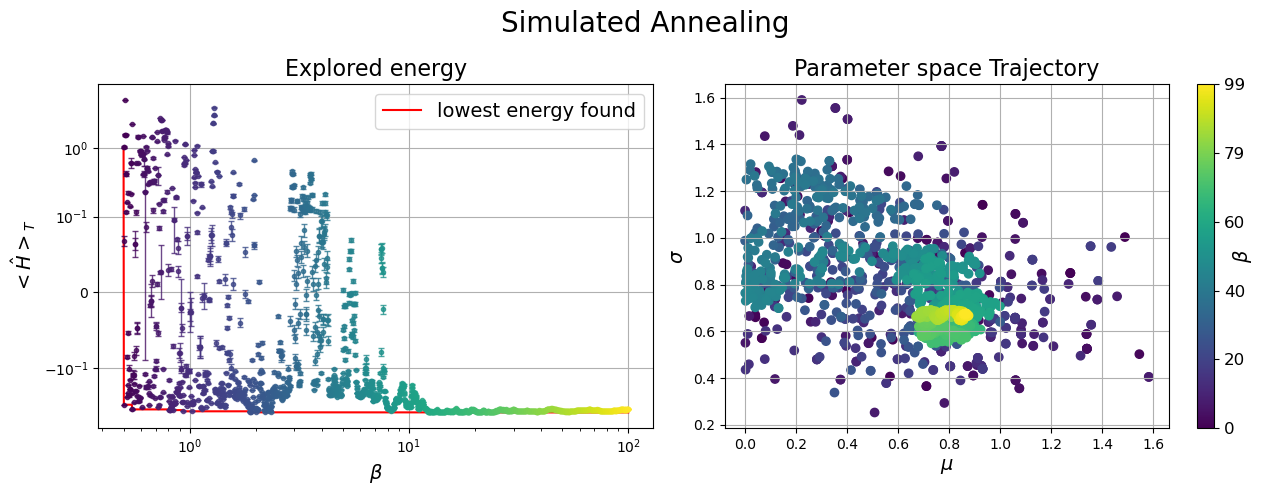

In [4]:
plt.figure(figsize=(13,5))
plt.suptitle('Simulated Annealing', fontsize=20)

# Load data
energy = np.loadtxt('./8.2/HamiltonianExpValue.dat', usecols=(1, 4, 5, 6))
betas = 1 / energy[:, 0]
parameters = np.loadtxt('./8.2/HamiltonianExpValue.dat', usecols=(2, 3))

# Left subplot
ax1 = plt.subplot(1,2,1)
plt.plot(betas, energy[:,2], c='red', label='lowest energy found')

# Create colormap
cmap = plt.cm.viridis  
colors = cmap(np.linspace(0, 1, len(np.unique(betas))))  # Generate colors based on unique betas
color_map = {beta: color for beta, color in zip(np.unique(betas), colors)}  # Map betas to colors

# Plot points with colors based on betas
for beta, (x, y, yerr) in zip(betas, zip(betas, energy[:,1], energy[:,3])):
    plt.errorbar(x, y, yerr=yerr, fmt='o', c=color_map[beta], alpha=0.8, markersize=3, elinewidth=1, capsize=2, capthick=1)

plt.xlabel('$\\beta$',fontsize=14)
plt.ylabel('$<\hat{H}>_T$', fontsize=14)
plt.yscale('symlog', linthresh=0.1)
plt.xscale('log')
plt.legend(fontsize=14)
plt.grid()
plt.title('Explored energy', fontsize=16)

# Right subplot
plt.subplot(1,2,2)
cmap = plt.cm.viridis  
colors = cmap(np.linspace(0, 1, len(np.unique(betas))))  # Generate colors based on unique betas
plt.scatter(parameters[:, 0], parameters[:, 1], c=colors[np.unique(betas, return_inverse=True)[1]])

plt.xlabel('$\mu$', fontsize=14)
plt.ylabel('$\sigma$', fontsize=14)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=12)
cbar.set_label('$\\beta$', fontsize=14)
cbar.ax.yaxis.set_label_coords(2.0, 0.5)
#cbar.set_ticks(np.linspace(min(betas), max(betas), 6))
cbar.set_ticklabels(np.linspace(min(betas), max(betas), 6, dtype=int))
plt.grid()
plt.title('Parameter space Trajectory', fontsize=16)

plt.tight_layout()
plt.show()

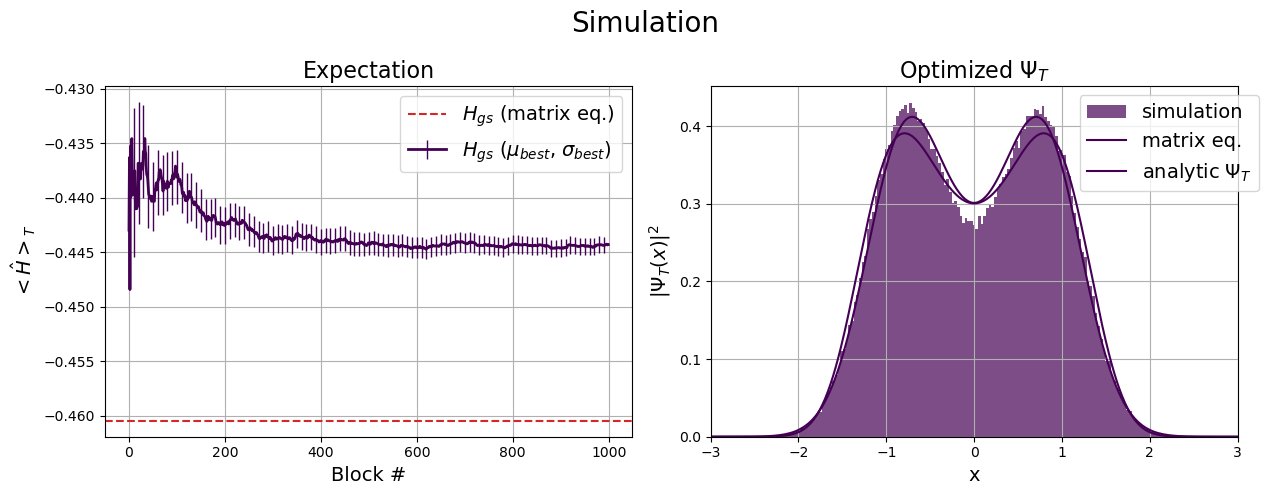

In [5]:
fig = plt.figure(figsize=(13, 5))
fig.suptitle('Simulation', fontsize=20)

plt.subplot(1, 2, 1)

# Definition of the trial wave function used for plotting analytical results
def TWF(x, mu, sigma):
    return (np.exp(-(x - mu) ** 2 / (2 * sigma ** 2)) + np.exp((-(x + mu) ** 2 / (2 * sigma ** 2)))) ** 2

# Load data
energy = np.loadtxt('./8.2/GSHamiltonianExpValue.dat', usecols=(0, 2, 3))
plt.errorbar(energy[:, 0], energy[:, 1], yerr=energy[:, 2], errorevery=10, c=colors[0], lw=2, elinewidth=1,
             ecolor=colors[2], label=r'$H_{gs}$ ($\mu_{best}$, $\sigma_{best}$)')

# Assuming E is defined somewhere
plt.axhline(E[0], ls='--', c='tab:red', label=r'$H_{gs}$ (matrix eq.)')

plt.grid()
plt.title('Expectation', fontsize=16)
plt.ylabel('$<\hat{H}>_T$', fontsize=14)
plt.xlabel('Block #', fontsize=14)
plt.legend(fontsize=14)

plt.subplot(1, 2, 2)

plt.title('Optimized $\Psi_{T}$', fontsize=16)

x = np.linspace(-a/2, a/2, N)

positions = np.loadtxt('./8.2/GSCoordinates.dat', usecols=(1))
plt.hist(positions, density=True, bins=np.linspace(-3, 3, 200), label='simulation', color=colors[0], alpha=0.7)
plt.plot(x, (psi[0]) ** 2, color=colors[3], label='matrix eq.')
plt.plot(np.linspace(-3, 3, 200), (1 / (1.5 * np.sqrt(np.pi))) * TWF(np.linspace(-3, 3, 200), 0.7902, 0.623073),
         color=colors[1], label='analytic $\Psi_T$')
plt.legend(fontsize=14, loc=(0.7, 0.7))
plt.xlabel('x', fontsize=14)
plt.ylabel('$|\Psi_T(x)|^2$', fontsize=14)
plt.grid()

plt.xlim(-3, 3)

plt.tight_layout()
plt.show()
